# GlobeStay Marketing Response Models (by Country)

**Channels**

Performance:
- Branded PPC (`cost_ppc_brand`)
- Non-Branded PPC (`cost_ppc_non_brand`)
- Metasearch (aggregated from Google Hotel Ads, Tripadvisor, Trivago, Other)
- Remarketing (`cost_remarketing`)
- Email (`cost_email`)

Digital Awareness:
- Display Advertising (`display_net_spend_eur`)
- YouTube (`yt_cost`)
- Facebook (`fb_cost`)
- Online Video (OLV) (`olv_spend_eur`)

Offline:
- Brand TV (`brandtv_net_spend_eur`)
- Direct-Response TV (`drtv_net_spend_eur`)
- Out-of-Home (OOH) (`ooh_net_spend_eur`)
- Radio (`radio_net_spend_eur`)
- Print (`print_net_spend_eur`)
- Cinema (`cinema_net_spend_eur`)

**Models:**
1. Log-Log
2. Adstock + Hill
3. ElasticNet

**Controls included:**
- Competition: `meta_comp_grp`, `ota_comp_grp` (log1p transformed)
- Seasonality: weekly Fourier terms (K=3)
- Trend: per-country time index
- Holidays: specified dummy columns (binary)

**Outputs:**
- Elasticities & marginal ROI (bookings per currency unit) for both models
- Diagnostic plots and response curves (matplotlib only, one chart per figure)
- Next-dollar **budget allocation recommendations** (raw & adjusted)

> **Note:** Financial ROI requires a contribution per booking. Here we report *bookings per currency*. Multiply by average contribution per booking to convert to financial ROI.

 ## 0) Setup

In [1]:
import os, math, warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import minimize
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")

 ## 1) Config

In [2]:
DATA_PATHS = [
    "../data/cleaned_globestay.parquet",
    "../data/cleaned_globestay.csv",
]

OUTPUT_DIR = "../output/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def save_csv(df, filename, index=False):
    path = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(path, index=index)
    print(f"Saved: {path}")

def save_excel(sheets: dict, filename: str):
    path = os.path.join(OUTPUT_DIR, filename)
    with pd.ExcelWriter(path, engine="xlsxwriter") as writer:
        for name, df in sheets.items():
            df.to_excel(writer, sheet_name=str(name)[:31], index=isinstance(df.index, pd.MultiIndex) or not df.index.equals(pd.RangeIndex(len(df))))
    print(f"Saved: {path}")

def safe_mape(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    mask = y_true > 0
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

 ## 2) Data Load

In [3]:
df = None
for p in DATA_PATHS:
    if os.path.exists(p):
        if p.endswith(".parquet"):
            df = pd.read_parquet(p)
        else:
            df = pd.read_csv(p)
        print(f"Loaded: {p}")
        break
if df is None:
    raise FileNotFoundError("Could not find data. Checked: " + ", ".join(DATA_PATHS))

Loaded: ../data/cleaned_globestay.parquet


 ## 3) Select Columns & Cleaning

In [4]:
SELECTED_COLS = [
    # Competition
    'meta_comp_grp','ota_comp_grp',
    # Controls
    'country','weekstart',
    # Holidays
    'presidentsday_us_ca','labourday_de_nw','boxingday','eastermonday','martinl_kingsday_us_ca',
    'remembrance_memorialday_us_ca','independenceday_us_ca','stvalentinesday','eastersunday',
    'christsascensionday_de_nw','labourday_us_ca','whitmonday_de_nw','bankholiday_gb_en',
    'thanksgivingday_us_ca','germanunityday_de_nw','mayday_gb_en','newyearsday','christmasday',

    # Performance Channels
    ## Email
    'cost_email','clicks_email','sales_emk',
    ## Non-brand PPC
    'cost_ppc_non_brand','sales_ppc_nonbrand','clicks_ppc_non_brand',
    ## Brand PPC
    'sales_ppc_brand','clicks_ppc_brand','cost_ppc_brand',
    ## Shopping site other
    'cost_shop_other','sales_shop_other','clicks_shop_other',
    ## Trivago
    'sales_shop_trivago','clicks_shop_trivago','cost_shop_trivago',
    ## Tripadvisor
    'clicks_shop_tripadvisor','sales_shop_tripadvisor','cost_shop_tripadvisor',
    ## Google Hotel Ads
    'cost_shop_googleha','sales_shop_googleha','clicks_shop_googleha',
    ## Remarketing
    'clicks_remarketing','cost_remarketing','sales_retargeting',

    # Digital Awareness Channels
    ## Display Advertising
    'display_net_spend_eur','display_imps',
    ## YouTube
    'yt_cost','yt_imps',
    ## Facebook
    'fb_cost','fb_imps',
    ## Online Video (OLV)
    'olv_net_spend_eur','olv_imps',

    # Offline Channels
    ## Brand TV
    'brandtv_net_spend_eur', 'brandtv_grp',
    ## Direct-Response TV
    'drtv_grp', 'drtv_net_spend_eur',
    ## Out-of-Home (OOH)
    'ooh_net_spend_eur',
    ## Radio
    'radio_net_spend_eur',
    ## Print
    'print_net_spend_eur',
    ## Cinema
    'cinema_net_spend_eur',

    # Dependent
    'totbookings','sales_interco','sales_direct','sales_strat_part',
    # Currency normalization
    'value_currency_rate',
]

df = df[SELECTED_COLS].copy()

df['weekstart'] = pd.to_datetime(df['weekstart'])
df = df.sort_values(['country','weekstart']).reset_index(drop=True)

 ## 4) Currency Normalization & Spend Aggregates

In [5]:
# EUR normalization for cost-like columns that are NOT already EUR
cost_like = [c for c in df.columns if c.startswith('cost_')] + ['yt_cost','fb_cost']
for c in cost_like:
    if c in df.columns:
        df[c+'_eur'] = df[c].fillna(0.0) * df['value_currency_rate'].fillna(1.0)

# Unified spend columns (EUR)
spend_map = {
    # Performance
    'email_spend_eur': 'cost_email_eur',
    'ppc_non_brand_spend_eur': 'cost_ppc_non_brand_eur',
    'ppc_brand_spend_eur': 'cost_ppc_brand_eur',
    'shop_other_spend_eur': 'cost_shop_other_eur',
    'trivago_spend_eur': 'cost_shop_trivago_eur',
    'tripadvisor_spend_eur': 'cost_shop_tripadvisor_eur',
    'googleha_spend_eur': 'cost_shop_googleha_eur',
    'remarketing_spend_eur': 'cost_remarketing_eur',
    # Digital
    'display_spend_eur': 'display_net_spend_eur',
    'yt_spend_eur': 'yt_cost_eur',
    'fb_spend_eur': 'fb_cost_eur',
    'olv_spend_eur': 'olv_net_spend_eur',
    # Offline
    'brandtv_spend_eur': 'brandtv_net_spend_eur',
    'drtv_spend_eur': 'drtv_net_spend_eur',
    'ooh_spend_eur': 'ooh_net_spend_eur',
    'radio_spend_eur': 'radio_net_spend_eur',
    'print_spend_eur': 'print_net_spend_eur',
    'cinema_spend_eur': 'cinema_net_spend_eur',
}
for new_col, src in spend_map.items():
    df[new_col] = df.get(src, 0.0).fillna(0.0)

# Aggregates
df['digital_imps_total'] = df[['display_imps','yt_imps','fb_imps','olv_imps']].fillna(0).sum(axis=1)
df['tv_grp_total'] = df[['brandtv_grp','drtv_grp']].fillna(0).sum(axis=1)

perf_cols = [k for k in spend_map if k.endswith('_spend_eur') and any(
    s in k for s in ['email','ppc_','shop_','trivago','tripadvisor','googleha','remarketing'])]
digital_cols = ['display_spend_eur','yt_spend_eur','fb_spend_eur','olv_spend_eur']
offline_cols = ['brandtv_spend_eur','drtv_spend_eur','ooh_spend_eur',
                'radio_spend_eur','print_spend_eur','cinema_spend_eur']
channel_feats = [c for c in perf_cols + digital_cols + offline_cols if c in df.columns]

df['perf_total_spend_eur'] = df[perf_cols].sum(axis=1)
df['digital_total_spend_eur'] = df[digital_cols].sum(axis=1)
df['offline_total_spend_eur'] = df[offline_cols].sum(axis=1)
df['total_spend_eur'] = df[['perf_total_spend_eur','digital_total_spend_eur','offline_total_spend_eur']].sum(axis=1)

 ## 5) Descriptive Tables

In [6]:
def summarize_by_country(data):
    rows = []
    for ctry in ['us','gb','de']:
        d = data[data['country']==ctry]
        if d.empty: continue
        spend_perf = d['perf_total_spend_eur'].sum()
        spend_dig  = d['digital_total_spend_eur'].sum()
        spend_off  = d['offline_total_spend_eur'].sum()
        total_spend = d['total_spend_eur'].sum()
        bookings = d['totbookings'].sum()
        rows.append({
            'country': ctry,
            'weeks': d.shape[0],
            'bookings_total': bookings,
            'spend_perf_eur': spend_perf,
            'spend_digital_eur': spend_dig,
            'spend_offline_eur': spend_off,
            'total_spend_eur': total_spend,
            'share_perf': spend_perf/total_spend if total_spend>0 else np.nan,
            'share_digital': spend_dig/total_spend if total_spend>0 else np.nan,
            'share_offline': spend_off/total_spend if total_spend>0 else np.nan,
            'cost_per_booking_eur': total_spend / bookings if bookings>0 else np.nan
        })
    return pd.DataFrame(rows)

country_summary = summarize_by_country(df)
channel_spend_cols = perf_cols + digital_cols + offline_cols
channel_rollup = df.groupby('country')[channel_spend_cols + ['totbookings']].sum().reset_index()
channel_rollup_long = channel_rollup.melt(id_vars=['country','totbookings'], var_name='channel', value_name='spend_eur')
channel_rollup_long['spend_share'] = channel_rollup_long.groupby('country')['spend_eur'].transform(lambda x: x/x.sum())

print("Country summary — spend & bookings", country_summary.round(2))
print("Channel rollup by country", channel_rollup_long.sort_values(['country','spend_eur'], ascending=[True, False]).round(2))

Country summary — spend & bookings   country  weeks  bookings_total  spend_perf_eur  spend_digital_eur  \
0      us    190     164467502.0    1.594251e+09        69111867.29   
1      gb    195     132115281.0    1.202594e+09        38739373.67   
2      de    191     111190840.0    7.665800e+08        21229867.26   

   spend_offline_eur  total_spend_eur  share_perf  share_digital  \
0       1.919885e+08     1.855352e+09        0.86           0.04   
1       3.328492e+07     1.274619e+09        0.94           0.03   
2       2.450136e+07     8.123112e+08        0.94           0.03   

   share_offline  cost_per_booking_eur  
0           0.10                 11.28  
1           0.03                  9.65  
2           0.03                  7.31  
Channel rollup by country    country  totbookings                  channel     spend_eur  spend_share
3       de  111190840.0  ppc_non_brand_spend_eur  5.065440e+08         0.62
12      de  111190840.0        trivago_spend_eur  9.417278e+07   

 ## 6) Plots (Timeseries, Mix, Shares)

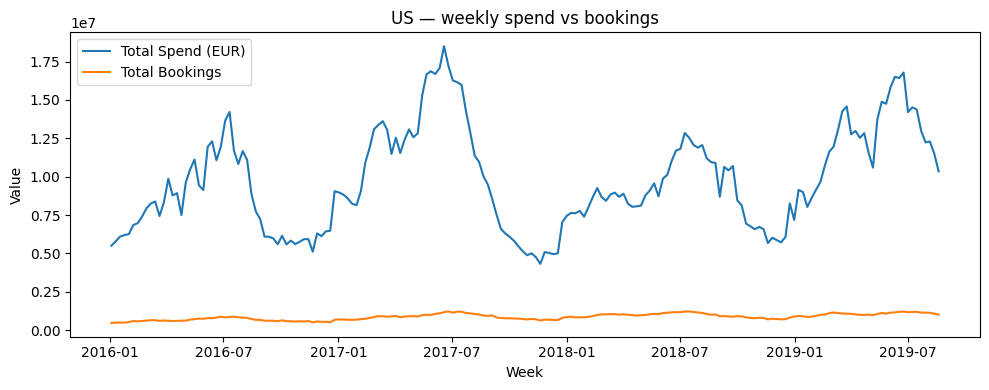

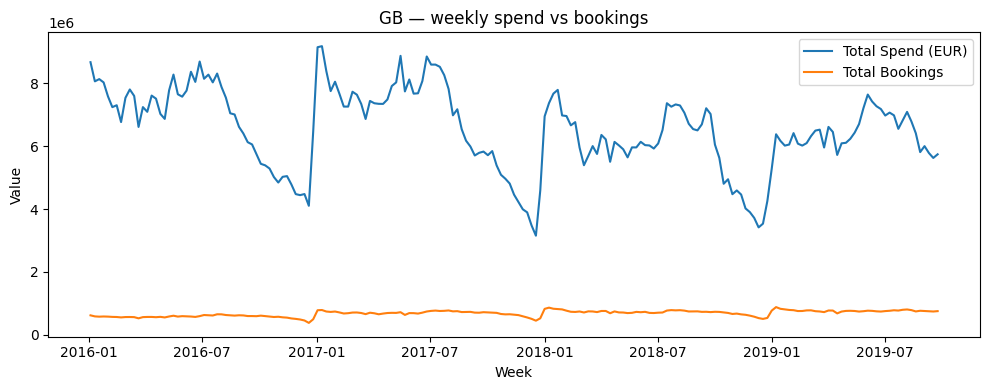

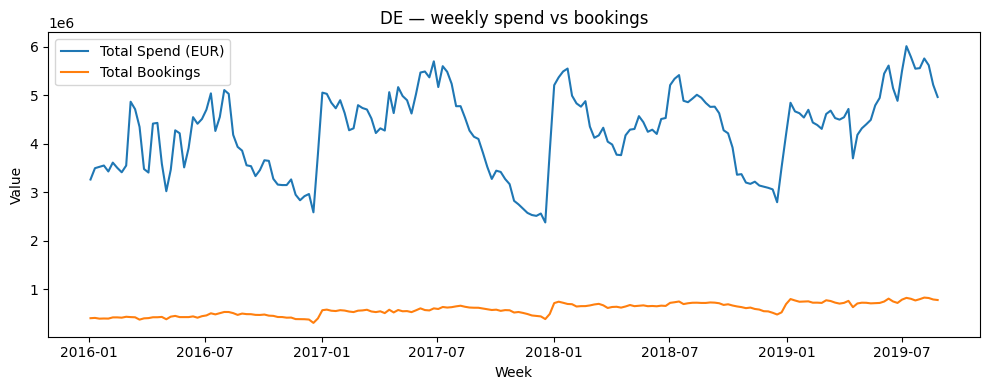

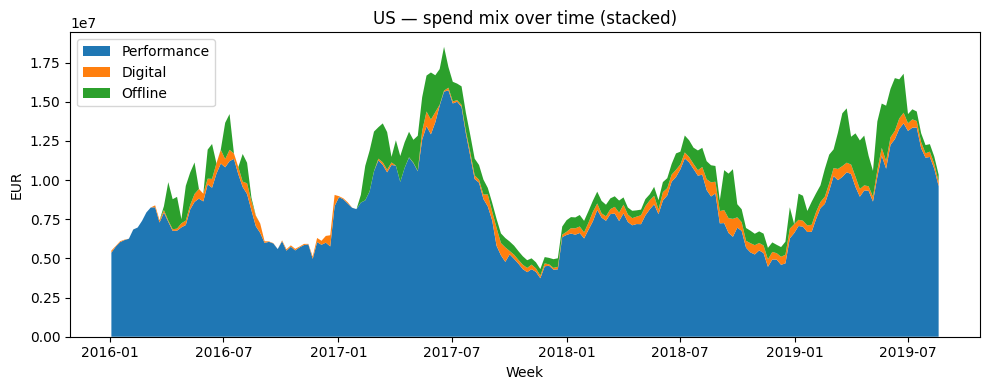

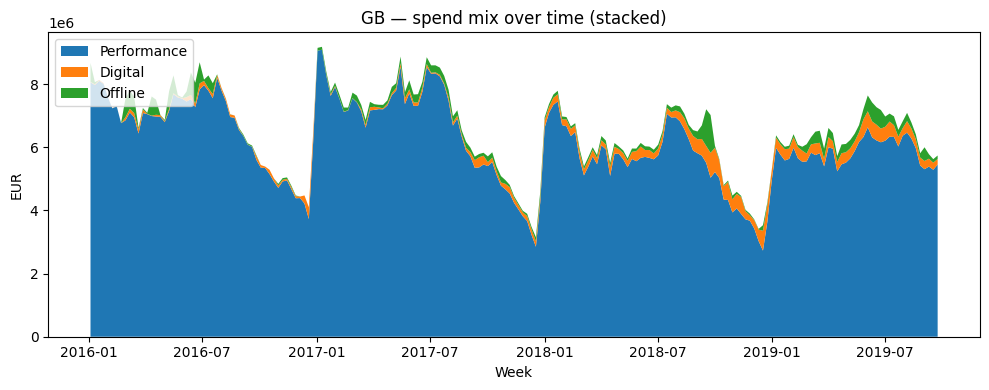

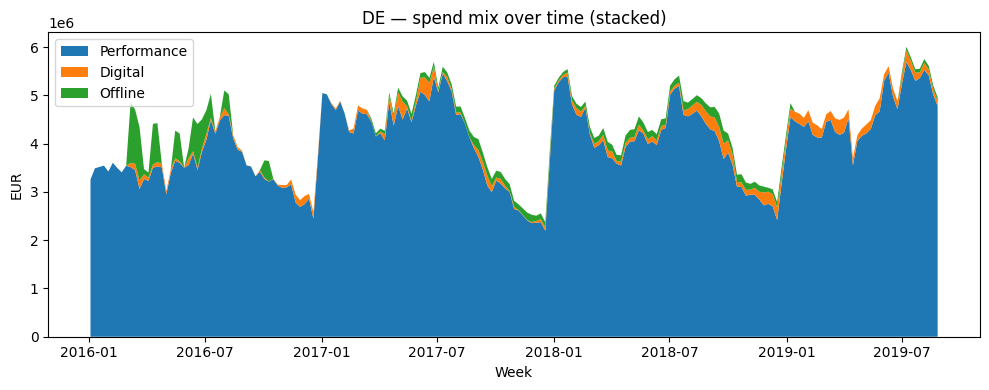

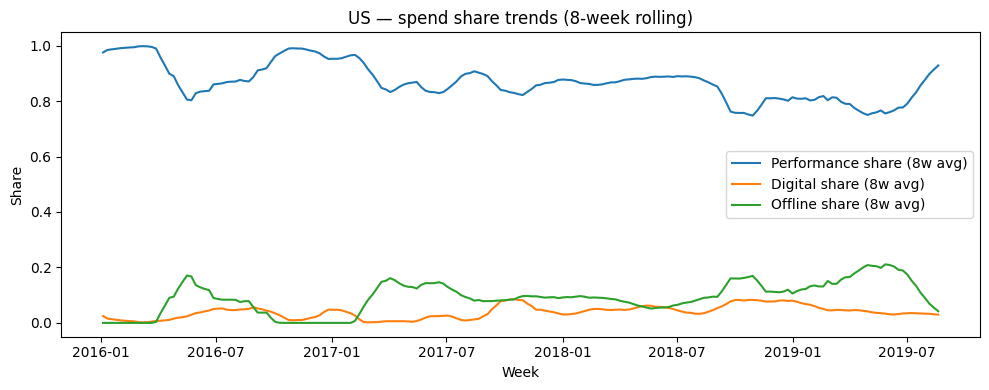

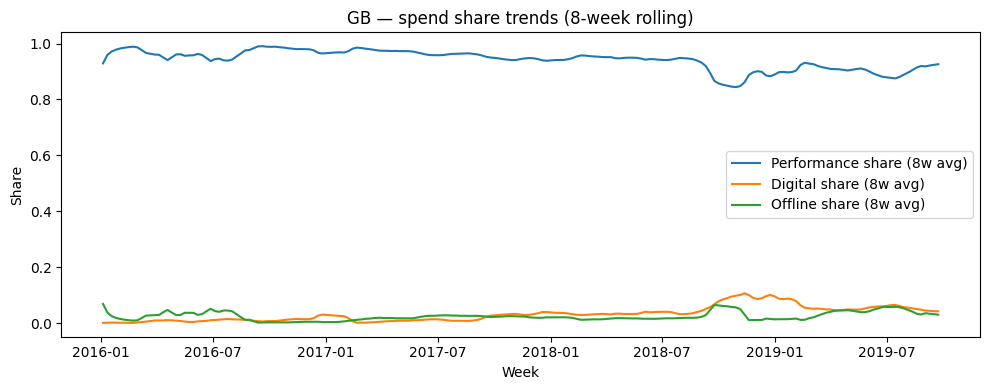

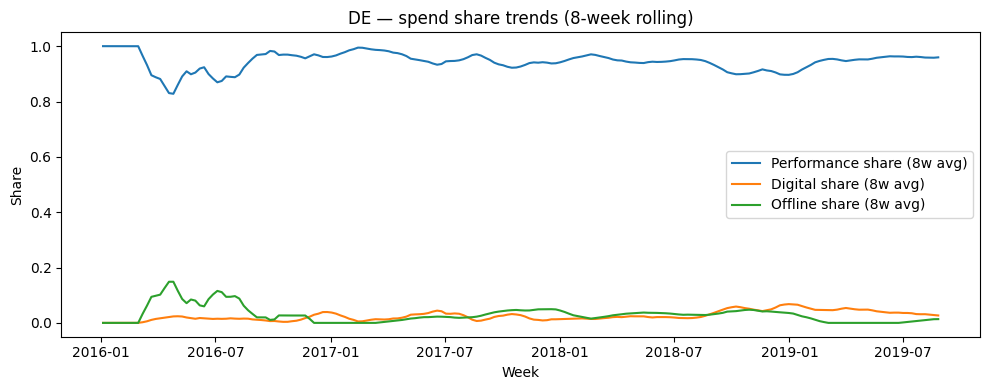

In [7]:
# Time series plots
for ctry in ['us','gb','de']:
    d = df[df['country']==ctry].copy()
    if d.empty: 
        continue
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(d['weekstart'], d['total_spend_eur'], label='Total Spend (EUR)')
    ax.plot(d['weekstart'], d['totbookings'], label='Total Bookings')
    ax.set_title(f"{ctry.upper()} — weekly spend vs bookings")
    ax.set_xlabel("Week"); ax.set_ylabel("Value")
    ax.legend(); fig.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, f"{ctry}_timeseries_spend_vs_bookings.png"), dpi=150)
    plt.show()

# Stacked area plot of spend mix over time
def plot_stacked_mix(d, ctry):
    cols = ['perf_total_spend_eur','digital_total_spend_eur','offline_total_spend_eur']
    d2 = d[['weekstart']+cols].copy().set_index('weekstart')
    fig, ax = plt.subplots(figsize=(10,4))
    ax.stackplot(d2.index, [d2[c] for c in cols], labels=['Performance','Digital','Offline'])
    ax.set_title(f"{ctry.upper()} — spend mix over time (stacked)")
    ax.set_xlabel("Week"); ax.set_ylabel("EUR")
    ax.legend(loc='upper left'); fig.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, f"{ctry}_stacked_spend_mix.png"), dpi=150)
    plt.show()

# Plot stacked spend mix for each country
for ctry in ['us','gb','de']:
    d = df[df['country']==ctry]
    if not d.empty:
        plot_stacked_mix(d, ctry)

# Spend share trends (8-week rolling average)
for ctry in ['us','gb','de']:
    d = df[df['country']==ctry].copy()
    if d.empty: 
        continue
    d = d.sort_values('weekstart')
    denom = d['total_spend_eur'].replace(0, np.nan)
    for col in ['perf_total_spend_eur','digital_total_spend_eur','offline_total_spend_eur']:
        d[col+'_share'] = d[col] / denom
    d_idx = d.set_index('weekstart')
    roll = d_idx[['perf_total_spend_eur_share','digital_total_spend_eur_share','offline_total_spend_eur_share']].rolling(8, min_periods=1).mean().reset_index()

    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(roll['weekstart'], roll['perf_total_spend_eur_share'], label='Performance share (8w avg)')
    ax.plot(roll['weekstart'], roll['digital_total_spend_eur_share'], label='Digital share (8w avg)')
    ax.plot(roll['weekstart'], roll['offline_total_spend_eur_share'], label='Offline share (8w avg)')
    ax.set_title(f"{ctry.upper()} — spend share trends (8-week rolling)")
    ax.set_xlabel("Week"); ax.set_ylabel("Share")
    ax.legend(); fig.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, f"{ctry}_spend_share_trends.png"), dpi=150)
    plt.show()

 ## 7) Seasonality Decomposition

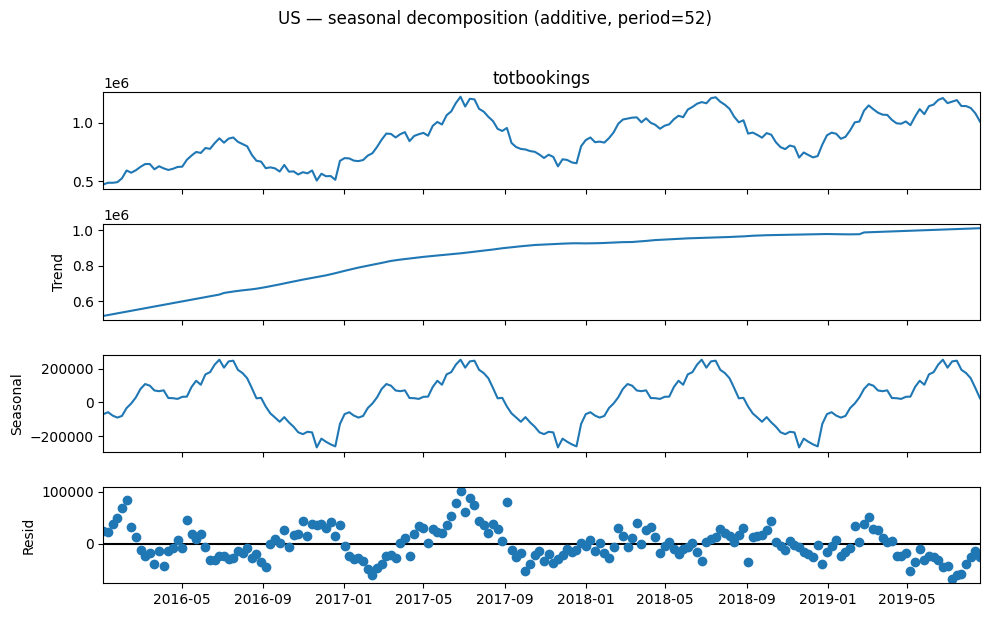

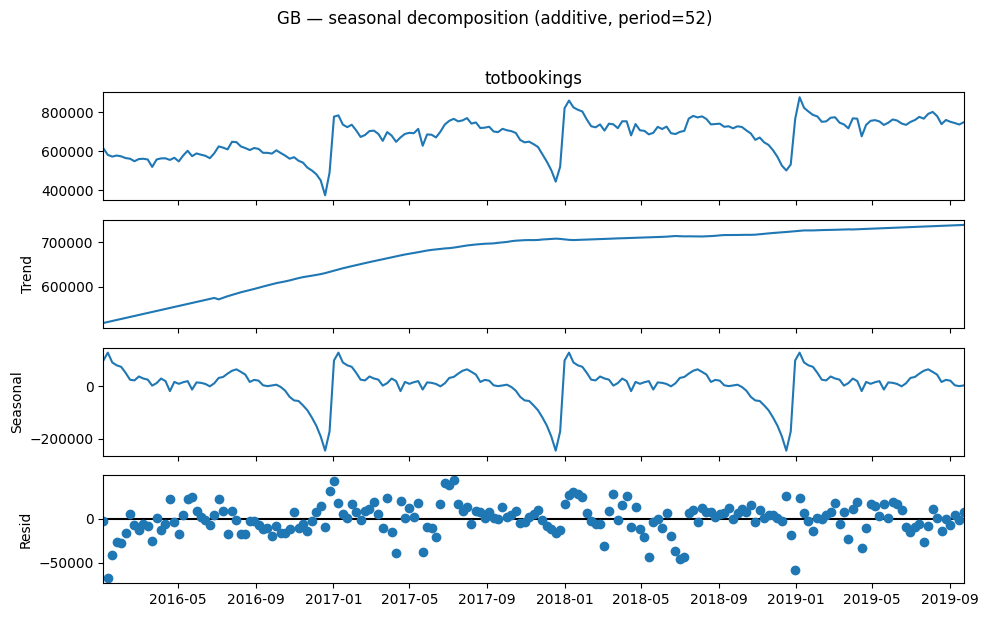

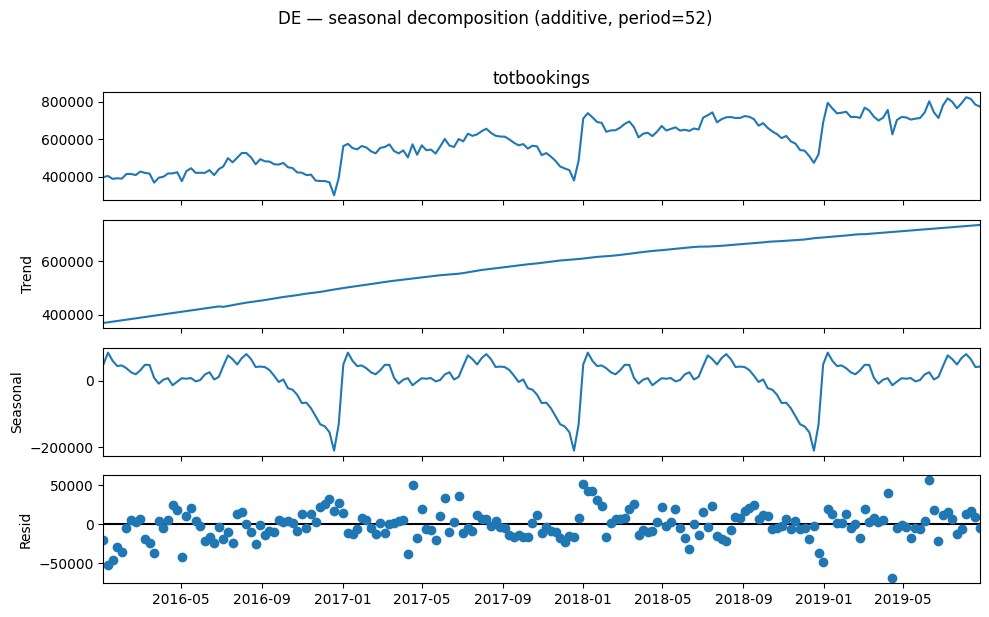

In [8]:
# Seasonal decomposition of bookings time series
for ctry in ['us','gb','de']:
    d = df[df['country']==ctry].set_index('weekstart').asfreq('W-MON').sort_index()
    if d.empty: continue
    y = d['totbookings'].interpolate().bfill()
    try:
        res = seasonal_decompose(y, model='additive', period=52, extrapolate_trend='freq')
        fig = res.plot()
        fig.set_size_inches(10,6)
        fig.suptitle(f"{ctry.upper()} — seasonal decomposition (additive, period=52)", y=1.02)
        fig.tight_layout()
        fig.savefig(os.path.join(OUTPUT_DIR, f"{ctry}_seasonal_decomp.png"), dpi=150)
        plt.show()
    except Exception as e:
        print(f"Decompose failed for {ctry}: {e}")

 ## 8) Modeling Utilities (Transforms, Models, Helpers)

In [9]:
# Fourier terms generation
def fourier_terms(n, t, period=52):
    t = np.asarray(t)
    terms = {}
    for k in range(1, n+1):
        terms[f'sin_{k}'] = np.sin(2*np.pi*k*t/period)
        terms[f'cos_{k}'] = np.cos(2*np.pi*k*t/period)
    return pd.DataFrame(terms, index=np.arange(len(t)))

# Channel transformation functions
def adstock(x, lam):
    x = np.asarray(x, dtype=float)
    s = np.zeros_like(x, dtype=float)
    for i in range(len(x)):
        s[i] = x[i] + (lam * s[i-1] if i>0 else 0.0)
    return s

# Hill saturation function
def hill_saturation(x, alpha, theta):
    x = np.asarray(x, dtype=float)
    xa = np.power(np.maximum(x, 0.0), alpha)
    ta = np.power(max(theta, 1e-9), alpha)
    denom = xa + ta
    return np.divide(xa, denom, out=np.zeros_like(xa), where=denom>0)

# Fit channel transformation parameters
def fit_channel_transform(x_train, lam_grid, alpha_grid, theta_grid):
    best = None; best_var = -np.inf
    for lam in lam_grid:
        s = adstock(x_train, lam)
        for alpha in alpha_grid:
            for theta in theta_grid:
                tr = hill_saturation(s, alpha, theta)
                v = np.var(tr)
                if v > best_var:
                    best_var = v
                    best = (lam, alpha, float(theta))
    lam, alpha, theta = best
    return {'lam': lam, 'alpha': alpha, 'theta': theta}

# Apply channel transformation
def apply_channel_transform(x, meta):
    s = adstock(np.asarray(x, dtype=float), meta['lam'])
    return hill_saturation(s, meta['alpha'], meta['theta'])

np.random.seed(42)

CONTROL_COLS_RAW = [
    'presidentsday_us_ca','labourday_de_nw','boxingday','eastermonday','martinl_kingsday_us_ca',
    'remembrance_memorialday_us_ca','independenceday_us_ca','stvalentinesday','eastersunday',
    'christsascensionday_de_nw','labourday_us_ca','whitmonday_de_nw','bankholiday_gb_en',
    'thanksgivingday_us_ca','germanunityday_de_nw','mayday_gb_en','newyearsday','christmasday',
]

# Create log-competition controls
df['log1p_meta_comp_grp'] = np.log1p(df['meta_comp_grp'].fillna(0.0))
df['log1p_ota_comp_grp']  = np.log1p(df['ota_comp_grp'].fillna(0.0))

# holidays as compact ints (optional, helps memory)
for c in CONTROL_COLS_RAW:
    if c in df.columns:
        df[c] = df[c].fillna(0).astype('int8')

CONTROL_COLS = ['log1p_meta_comp_grp','log1p_ota_comp_grp'] + CONTROL_COLS_RAW

 ## 9) Modeling, Evaluation & Attribution (per Country)

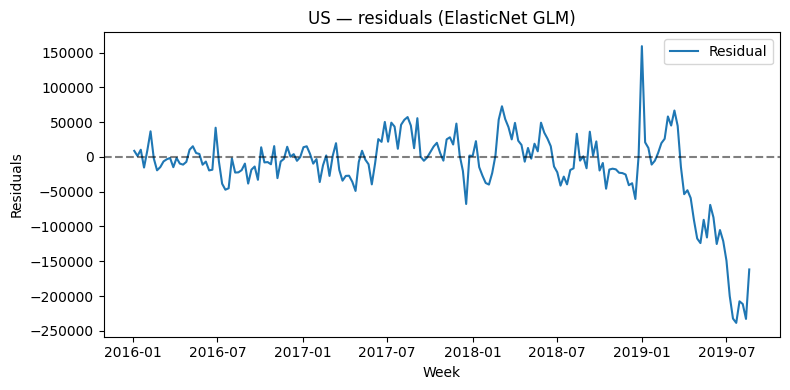

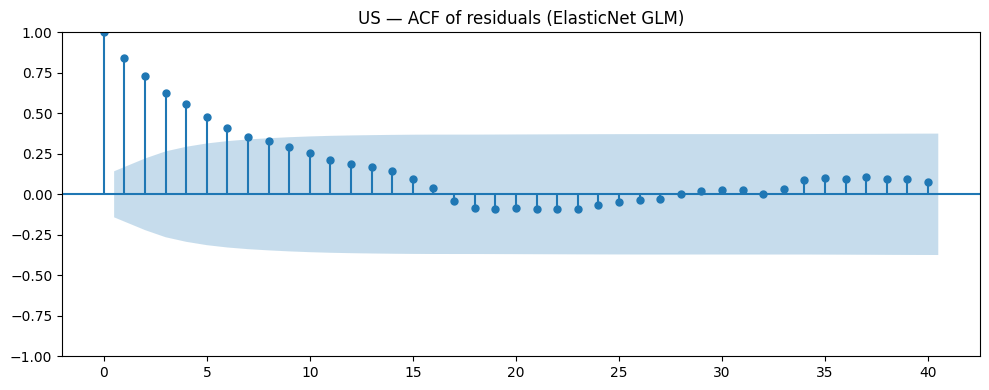

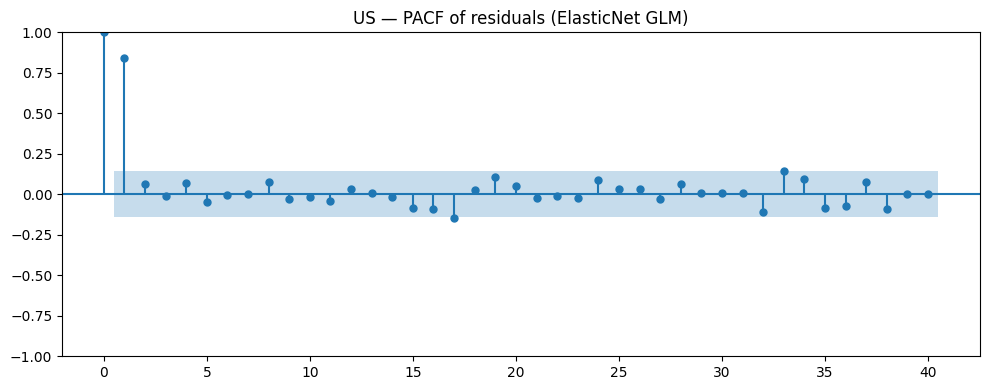

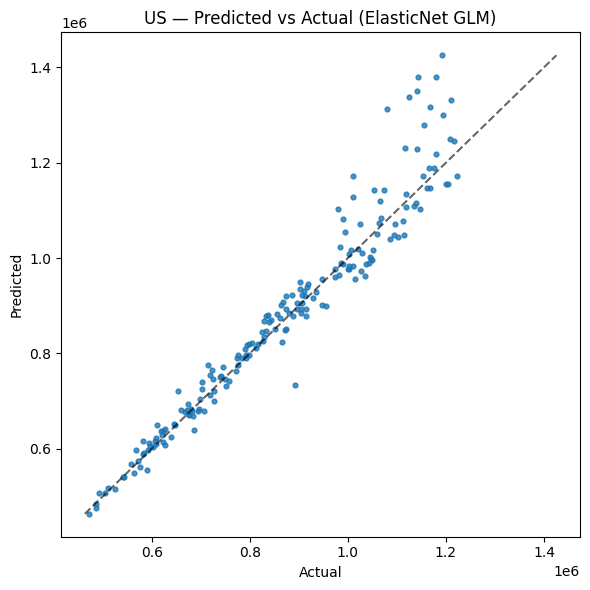

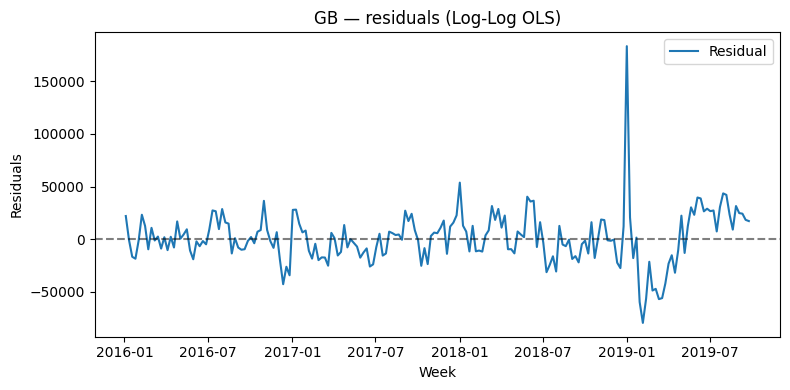

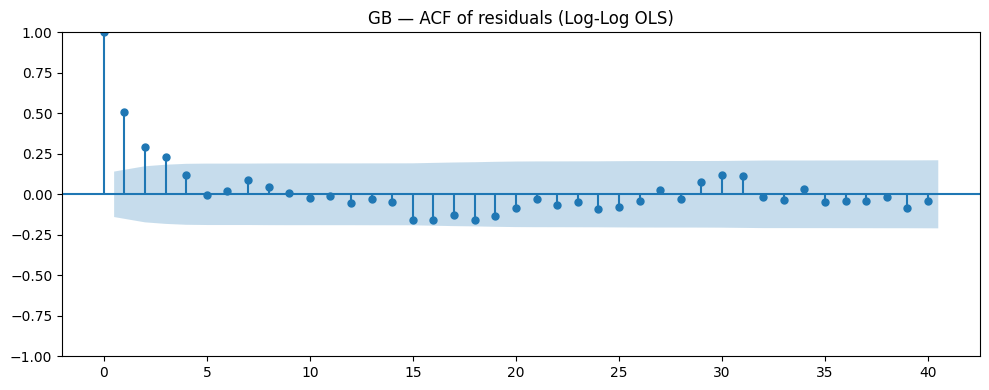

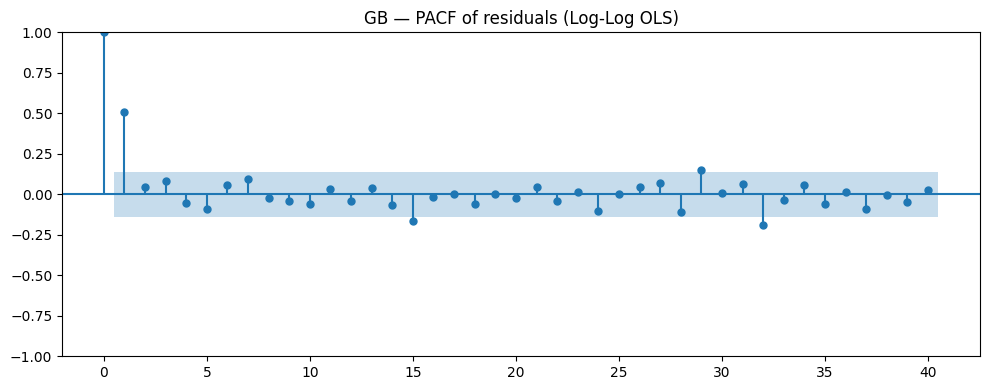

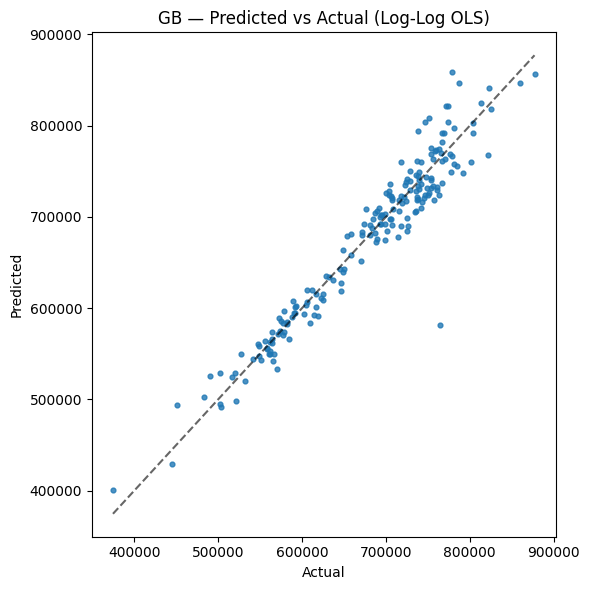

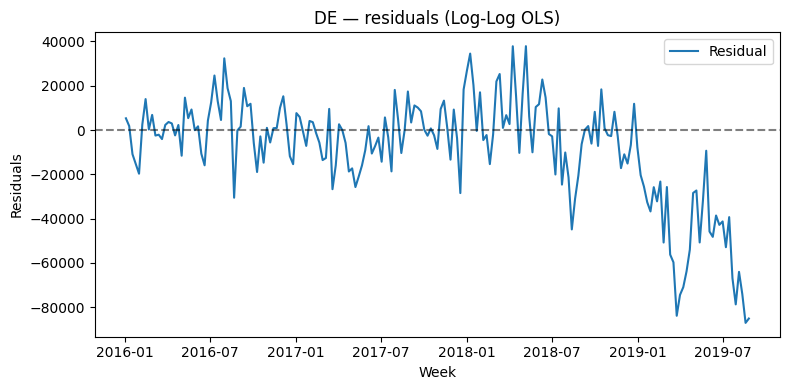

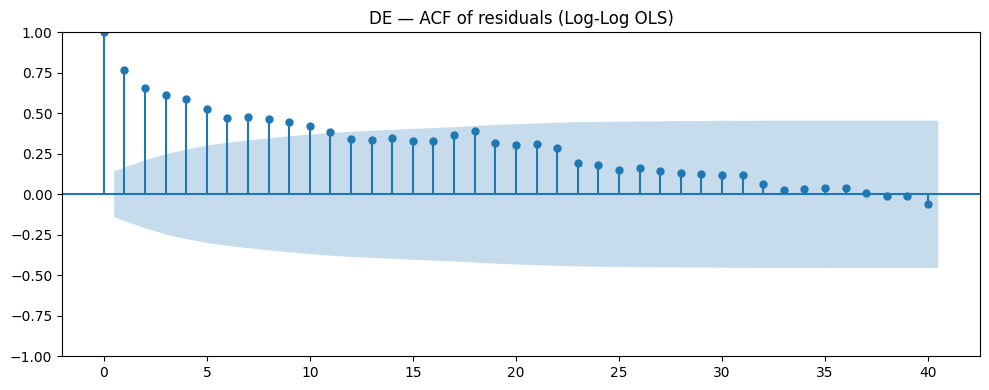

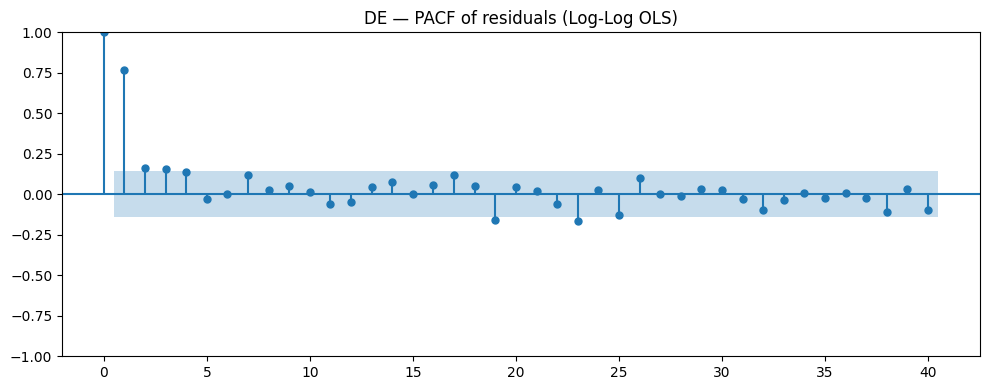

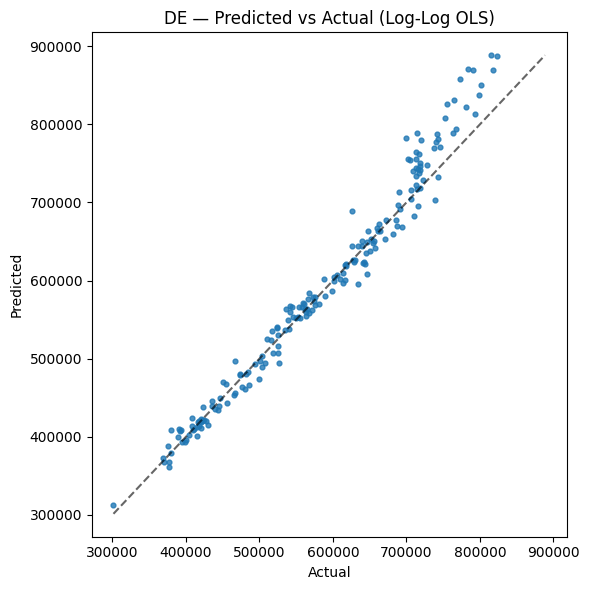

In [10]:
results_models = []
elasticity_rows, roi_rows = [], []
attribution_outputs = {}
country_models = {}

# Modeling per country
for ctry in ['us','gb','de']:
    d = df[df['country']==ctry].copy().reset_index(drop=True)
    if d.empty or d.shape[0] < 52:
        continue

    d = d.sort_values('weekstart').reset_index(drop=True)
    d['t'] = np.arange(len(d))
    fourier = fourier_terms(n=3, t=d['t'].values, period=52)
    d = pd.concat([d, fourier.reset_index(drop=True)], axis=1)
    d['trend'] = d['t']; d['trend2'] = d['t']**2

    # split
    split_idx = int(len(d)*0.8)
    train = d.iloc[:split_idx].copy()
    test  = d.iloc[split_idx:].copy()

    # Build features
    # Log-Log: log1p(channel)
    X_cols_ll = []
    for col in channel_feats:
        train[f"log1p_{col}"] = np.log1p(train[col].fillna(0.0))
        test[f"log1p_{col}"]  = np.log1p(test[col].fillna(0.0))
        d[f"log1p_{col}"]     = np.log1p(d[col].fillna(0.0))
        X_cols_ll.append(f"log1p_{col}")

    # Adstock+Hill
    lam_grid = [0.3, 0.5, 0.7, 0.85]
    alpha_grid = [0.7, 1.0, 1.3]
    trans_meta = {}
    trans_cols = []
    for col in channel_feats:
        theta_grid = [np.percentile(train[col].fillna(0.0).values, q) for q in (50, 65, 80)]
        meta = fit_channel_transform(train[col].fillna(0.0).values, lam_grid, alpha_grid, theta_grid)
        trans_meta[col] = meta
        train[f"adhill_{col}"] = apply_channel_transform(train[col].fillna(0.0).values, meta)
        test[f"adhill_{col}"]  = apply_channel_transform(test[col].fillna(0.0).values, meta)
        d[f"adhill_{col}"]     = apply_channel_transform(d[col].fillna(0.0).values, meta)
        trans_cols.append(f"adhill_{col}")

    # Final feature lists
    extra_cols = CONTROL_COLS + ['trend','trend2'] + list(fourier.columns)
    X_cols_ll     = X_cols_ll + extra_cols
    X_cols_adhill = trans_cols + extra_cols
    en_features   = channel_feats + extra_cols

    y_train = train['totbookings'].values
    y_test  = test['totbookings'].values

    # Model 1: Log-Log OLS
    Xtr = train[X_cols_ll].fillna(0.0).values
    Xte = test[X_cols_ll].fillna(0.0).values
    ll_model = LinearRegression().fit(Xtr, np.log1p(y_train))
    pred_log_train = ll_model.predict(Xtr)
    smear = np.exp(np.mean(np.log1p(y_train) - pred_log_train))
    yhat_test = np.exp(ll_model.predict(Xte)) * smear - 1.0
    yhat_test = np.maximum(yhat_test, 0.0)
    r2_ll = r2_score(y_test, yhat_test)
    rmse_ll = math.sqrt(mean_squared_error(y_test, yhat_test))
    mape_ll = safe_mape(y_test, yhat_test)
    results_models.append({'country':ctry,'model':'Log-Log OLS','R2':r2_ll,'RMSE':rmse_ll,'MAPE%':mape_ll})

    # Model 2: Adstock + Hill OLS
    Xtr2 = train[X_cols_adhill].fillna(0.0).values
    Xte2 = test[X_cols_adhill].fillna(0.0).values
    ah_model = LinearRegression().fit(Xtr2, y_train)
    yhat_test2 = ah_model.predict(Xte2)
    yhat_test2 = np.maximum(yhat_test2, 0.0)
    r2_ah = r2_score(y_test, yhat_test2)
    rmse_ah = math.sqrt(mean_squared_error(y_test, yhat_test2))
    mape_ah = safe_mape(y_test, yhat_test2)
    results_models.append({'country':ctry,'model':'Adstock+Hill OLS','R2':r2_ah,'RMSE':rmse_ah,'MAPE%':mape_ah})

    # Model 3: ElasticNet (CV)
    en = Pipeline([
        ('scaler', StandardScaler(with_mean=True, with_std=True)),
        ('model', ElasticNetCV(l1_ratio=[0.2,0.5,0.8], alphas=np.logspace(-4, 0, 15),
                               max_iter=8000, cv=5, n_jobs=None, random_state=42))
    ])
    Xtr3 = train[en_features].fillna(0.0).values
    Xte3 = test[en_features].fillna(0.0).values
    en.fit(Xtr3, y_train)
    yhat_test3 = en.predict(Xte3)
    yhat_test3 = np.maximum(yhat_test3, 0.0)
    r2_en = r2_score(y_test, yhat_test3)
    rmse_en = math.sqrt(mean_squared_error(y_test, yhat_test3))
    mape_en = safe_mape(y_test, yhat_test3)
    results_models.append({'country':ctry,'model':'ElasticNet GLM','R2':r2_en,'RMSE':rmse_en,'MAPE%':mape_en})

    # Choose best by R2
    perf_df = pd.DataFrame([r for r in results_models if r['country']==ctry]).sort_values('R2', ascending=False)
    best = perf_df.iloc[0]['model']

    if best == 'Adstock+Hill OLS':
        best_kind = 'adhill'; best_model = ah_model; Xcols_best = X_cols_adhill
    elif best == 'Log-Log OLS':
        best_kind = 'loglog'; best_model = (ll_model, smear); Xcols_best = X_cols_ll
    else:  # 'ElasticNet GLM'
        best_kind = 'elasticnet'; best_model = en; Xcols_best = en_features

    # Persist country model bundle (for sims/optimization)
    country_models[ctry] = {
        'kind': best_kind,
        'model': best_model,
        'X_cols_ll': X_cols_ll,
        'X_cols_adhill': X_cols_adhill,
        'en_features': en_features,
        'Xcols_best': Xcols_best,
        'df_full': d,  # with engineered cols
        'train_idx': slice(0, split_idx),
        'test_idx': slice(split_idx, len(d)),
        'trans_meta': trans_meta,
    }

    # Residual plots & diagnostics (on full)
    def predict_all(dall):
        if best_kind == 'adhill':
            return ah_model.predict(dall[X_cols_adhill].fillna(0.0).values)
        elif best_kind == 'loglog':
            ll, s = best_model
            return np.maximum(np.exp(ll.predict(dall[X_cols_ll].fillna(0.0).values))*s - 1.0, 0.0)
        else:  # 'elasticnet'
            return en.predict(dall[en_features].fillna(0.0).values)

    yhat_all = predict_all(d)
    resid = d['totbookings'].values - yhat_all
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(d['weekstart'], resid, label='Residual')
    ax.axhline(0, linestyle='--', color='k', alpha=0.5)
    ax.set_title(f"{ctry.upper()} — residuals ({best})")
    ax.set_xlabel("Week"); ax.set_ylabel("Residuals")
    ax.legend(); fig.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, f"{ctry}_residuals_{best_kind}.png"), dpi=150)
    plt.show()

    # ACF / PACF plots
    try:
        fig = plt.figure(figsize=(10,4))
        plot_acf(resid, lags=40, ax=plt.gca())
        plt.title(f"{ctry.upper()} — ACF of residuals ({best})")
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f"{ctry}_acf_{best_kind}.png"), dpi=150)
        plt.show()

        fig = plt.figure(figsize=(10,4))
        plot_pacf(resid, lags=40, ax=plt.gca(), method='ywm')
        plt.title(f"{ctry.upper()} — PACF of residuals ({best})")
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f"{ctry}_pacf_{best_kind}.png"), dpi=150)
        plt.show()
    except Exception as e:
        print("ACF/PACF plotting skipped:", e)

    # Pred vs actual
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(d['totbookings'], yhat_all, s=12, alpha=0.8)
    lo = float(min(d['totbookings'].min(), yhat_all.min()))
    hi = float(max(d['totbookings'].max(), yhat_all.max()))
    ax.plot([lo, hi],[lo, hi], '--', color='k', alpha=0.6)
    ax.set_title(f"{ctry.upper()} — Predicted vs Actual ({best})")
    ax.set_xlabel("Actual"); ax.set_ylabel("Predicted")
    fig.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, f"{ctry}_pred_vs_actual_{best_kind}.png"), dpi=150)
    plt.show()

    # Elasticities & Marginal ROI (computed over TEST period)
    test_df = d.iloc[split_idx:].copy()

    # Function to predict from modified dataframe
    def predict_from(modified):
        if best_kind == 'adhill':
            return ah_model.predict(modified[X_cols_adhill].fillna(0.0).values)
        elif best_kind == 'loglog':
            ll, s = best_model
            return np.maximum(np.exp(ll.predict(modified[X_cols_ll].fillna(0.0).values))*s - 1.0, 0.0)
        else:  # 'elasticnet'
            return en.predict(modified[en_features].fillna(0.0).values)

    base_mean = predict_from(test_df).mean()

    # Per-channel elasticity & marginal ROI
    for ch in channel_feats:
        d_mod = d.copy()
        d_mod[ch] = d_mod[ch] * 1.01
        # refresh transforms for this channel if adhill
        if best_kind == 'adhill':
            meta = trans_meta[ch]
            d_mod[f'adhill_{ch}'] = apply_channel_transform(d_mod[ch].fillna(0.0).values, meta)
        elif best_kind == 'loglog':
            d_mod[f'log1p_{ch}'] = np.log1p(d_mod[ch].fillna(0.0))
        new_mean = predict_from(d_mod.iloc[split_idx:]).mean()
        pct_y = (new_mean - base_mean)/max(1e-9, base_mean)
        elasticity = pct_y / 0.01

        # Marginal ROI ~ dY / dSpend around current mean
        current = d[ch].mean()
        delta_sp = max(0.01, current*0.01)
        d_mod2 = d.copy()
        d_mod2[ch] = d_mod2[ch] + delta_sp
        if best_kind == 'adhill':
            meta = trans_meta[ch]
            d_mod2[f'adhill_{ch}'] = apply_channel_transform(d_mod2[ch].fillna(0.0).values, meta)
        elif best_kind == 'loglog':
            d_mod2[f'log1p_{ch}'] = np.log1p(d_mod2[ch].fillna(0.0))
        mroi = (predict_from(d_mod2.iloc[split_idx:]).mean() - base_mean) / delta_sp

        elasticity_rows.append({'country': ctry, 'channel': ch, 'elasticity': float(elasticity)})
        roi_rows.append({'country': ctry, 'channel': ch, 'marginal_roi_bookings_per_eur': float(mroi)})

    # Attribution
    feats = {'adhill': X_cols_adhill, 'loglog': X_cols_ll}.get(best_kind, en_features)
    full_pred = predict_from(d)
    rows = []
    for i in range(len(d)):
        row = {
            'weekstart': d.loc[i, 'weekstart'],
            'country': ctry,
            'pred': float(full_pred[i]),
            'actual': float(d.loc[i, 'totbookings'])
        }
        rows.append(row)
    attr_df = pd.DataFrame(rows)

    # Compute per-channel contributions by full-series zeroing
    channel_contrib = {}
    for ch in channel_feats:
        d_zero = d.copy()
        d_zero[ch] = 0.0
        if best_kind == 'adhill':
            meta = trans_meta[ch]
            d_zero[f'adhill_{ch}'] = apply_channel_transform(d_zero[ch].values, meta)
        elif best_kind == 'loglog':
            d_zero[f'log1p_{ch}'] = np.log1p(d_zero[ch].values)

        pred_zero = predict_from(d_zero)
        delta = np.maximum(full_pred - pred_zero, 0.0)
        channel_contrib[ch] = delta

    for ch, vec in channel_contrib.items():
        attr_df[ch] = vec.astype(float)

    # Baseline = pred - sum(contribs), floor at 0
    sum_contrib = np.sum([attr_df[ch].values for ch in channel_feats], axis=0)
    attr_df['baseline'] = np.maximum(attr_df['pred'].values - sum_contrib, 0.0)
    attribution_outputs[ctry] = attr_df

 ## 10) Results Tables

In [11]:
model_results_df = pd.DataFrame(results_models).sort_values(['country','R2'], ascending=[True, False])
print("Model results per country (R², RMSE, MAPE)", model_results_df.round(4))

elasticity_df = pd.DataFrame(elasticity_rows)
roi_df = pd.DataFrame(roi_rows)

nonzero_channels = [ch for ch in channel_feats if df[ch].sum()>0]
elasticity_df = elasticity_df[elasticity_df['channel'].isin(nonzero_channels)].copy()
roi_df = roi_df[roi_df['channel'].isin(nonzero_channels)].copy()

elas_pivot = elasticity_df.pivot_table(index='channel', columns='country', values='elasticity')
roi_pivot   = roi_df.pivot_table(index='channel', columns='country', values='marginal_roi_bookings_per_eur')

print("Elasticities by channel & country", elas_pivot.round(3).sort_index())
print("Marginal ROI (bookings per €) by channel & country", roi_pivot.round(4).sort_index())


Model results per country (R², RMSE, MAPE)   country             model      R2         RMSE    MAPE%
6      de       Log-Log OLS  0.6391   49335.9516   5.9160
8      de    ElasticNet GLM  0.6135   51052.4141   6.3975
7      de  Adstock+Hill OLS  0.5493   55127.7471   6.5583
3      gb       Log-Log OLS -1.0836   45040.0744   4.4984
5      gb    ElasticNet GLM -2.0111   54144.9017   4.5015
4      gb  Adstock+Hill OLS -4.5187   73301.1906   8.2415
2      us    ElasticNet GLM  0.2692  115700.6915   8.5601
0      us       Log-Log OLS -0.5223  166990.0263  12.1395
1      us  Adstock+Hill OLS -1.1618  198995.2022  17.3445
Elasticities by channel & country country                     de     gb     us
channel                                     
brandtv_spend_eur        0.000 -0.000 -0.015
cinema_spend_eur         0.000  0.000  0.000
display_spend_eur       -0.003 -0.001  0.005
drtv_spend_eur           0.000 -0.002  0.039
fb_spend_eur            -0.000 -0.004  0.004
googleha_spend_eur       0.0

 ## 11) Simulations

In [12]:
# Simulation function: adjust spends by multipliers, hold total budget constant
def simulate_shift(ctry, adjustments: dict):
    bundle = country_models.get(ctry)
    if not bundle:
        return {'country': ctry, 'error': 'No model bundle available'}

    kind = bundle['kind']
    model = bundle['model']
    d_full = bundle['df_full'].copy()
    split = bundle['test_idx']
    feats = bundle['Xcols_best']
    trans_meta = bundle['trans_meta']

    # compute base mean (test)
    def predict_from(dcopy):
        if kind == 'adhill':
            return model.predict(dcopy[bundle['X_cols_adhill']].fillna(0.0).values)
        elif kind == 'loglog':
            ll, smear = model
            return np.maximum(np.exp(ll.predict(dcopy[bundle['X_cols_ll']].fillna(0.0).values))*smear - 1.0, 0.0)
        else:  # 'elasticnet'
            return model.predict(dcopy[bundle['en_features']].fillna(0.0).values)

    base_pred = predict_from(d_full.iloc[split]).mean()

    spend_cols = channel_feats.copy()
    base_spends = d_full[spend_cols].mean()

    # apply requested multipliers
    adj_spends = base_spends.copy()
    for k, v in adjustments.items():
        if k in adj_spends.index:
            adj_spends[k] *= float(v)

    # hold total budget constant
    total_base = base_spends.sum()
    total_fixed = adj_spends[adj_spends.index.isin(adjustments.keys())].sum()
    remaining = [c for c in spend_cols if c not in adjustments]
    remaining_base = base_spends[remaining].sum()
    scale_other = (total_base - total_fixed) / max(1e-9, remaining_base)
    for c in remaining:
        adj_spends[c] *= scale_other

    d2 = d_full.copy()
    for c in spend_cols:
        d2[c] = adj_spends[c]

    if kind == 'adhill':
        for c in spend_cols:
            meta = trans_meta[c]
            d2[f'adhill_{c}'] = apply_channel_transform(d2[c].fillna(0.0).values, meta)
    elif kind == 'loglog':
        for c in spend_cols:
            d2[f'log1p_{c}'] = np.log1p(d2[c].fillna(0.0))

    adj_pred = predict_from(d2.iloc[split]).mean()
    uplift = (adj_pred - base_pred) / max(1e-9, base_pred)

    return {
        'country': ctry,
        'base_pred_avg_weekly_bookings': float(base_pred),
        'adj_pred_avg_weekly_bookings': float(adj_pred),
        'uplift_pct': float(uplift),
        'total_budget_eur': float(total_base),
        'adj_spend_vector_eur': {k: float(v) for k,v in adj_spends.items()},
    }

# Scenario examples
sc1 = [simulate_shift(ctry, {'ppc_brand_spend_eur':1.10}) for ctry in ['us','gb','de']]
sc2 = [simulate_shift(ctry, {'brandtv_spend_eur':0.90, 'drtv_spend_eur':0.90}) for ctry in ['us','gb','de']]
sim_df = pd.DataFrame(sc1 + sc2)
print("Budget reallocation simulations (avg weekly)", sim_df.round(4))


Budget reallocation simulations (avg weekly)   country  base_pred_avg_weekly_bookings  adj_pred_avg_weekly_bookings  \
0      us                   1.091438e+06                  1.049039e+06   
1      gb                   7.571026e+05                  8.047004e+05   
2      de                   7.635774e+05                  7.467241e+05   
3      us                   1.091438e+06                  1.048276e+06   
4      gb                   7.571026e+05                  8.036554e+05   
5      de                   7.635774e+05                  7.488059e+05   

   uplift_pct  total_budget_eur  \
0     -0.0388      9.765009e+06   
1      0.0629      6.536507e+06   
2     -0.0221      4.252938e+06   
3     -0.0395      9.765009e+06   
4      0.0615      6.536507e+06   
5     -0.0193      4.252938e+06   

                                adj_spend_vector_eur  
0  {'email_spend_eur': 0.0, 'ppc_non_brand_spend_...  
1  {'email_spend_eur': 0.0, 'ppc_non_brand_spend_...  
2  {'email_spend_eur': 0.

 ## 12) Constrained Optimization (Fixed Budget, Max Bookings)

In [13]:
# Budget optimization function
def optimize_budget(ctry):
    bundle = country_models.get(ctry)
    if not bundle:
        return {'country': ctry, 'error': 'No model bundle available'}

    kind = bundle['kind']
    model = bundle['model']
    d_full = bundle['df_full'].copy()
    trans_meta = bundle['trans_meta']

    test_slice = bundle['test_idx']

    spend_cols_all = channel_feats.copy()
    base_spends_s = d_full[spend_cols_all].mean()
    nonzero_cols = [c for c in spend_cols_all if base_spends_s[c] > 0]
    zero_cols    = [c for c in spend_cols_all if base_spends_s[c] == 0]

    if len(nonzero_cols) == 0:
        return {'country': ctry, 'error': 'All channels have zero base spend'}

    spend_cols = nonzero_cols
    base_spends = base_spends_s[spend_cols].values
    total_budget = float(base_spends.sum())

    def predict_from_spends(sp_vector):
        d2 = d_full.copy()
        for i, c in enumerate(spend_cols):
            d2[c] = sp_vector[i]
        for c in zero_cols:
            d2[c] = 0.0

        if kind == 'adhill':
            for c in spend_cols + zero_cols:
                d2[f'adhill_{c}'] = apply_channel_transform(d2[c].fillna(0.0).values, trans_meta[c])
            preds = model.predict(d2[bundle['X_cols_adhill']].fillna(0.0).values)
        elif kind == 'loglog':
            for c in spend_cols + zero_cols:
                d2[f'log1p_{c}'] = np.log1p(d2[c].fillna(0.0))
            ll, smear = model
            preds = np.maximum(np.exp(ll.predict(d2[bundle['X_cols_ll']].fillna(0.0).values))*smear - 1.0, 0.0)
        else:  # 'elasticnet'
            preds = model.predict(d2[bundle['en_features']].fillna(0.0).values)

        return float(np.mean(preds[test_slice]))

    # bounds and constraints
    lb = 0.30 * base_spends
    ub = 2.00 * base_spends
    bounds = list(zip(lb, ub))
    cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - total_budget}, )
    x0 = base_spends.copy()

    res = minimize(lambda x: -predict_from_spends(x),
                   x0=x0, bounds=bounds, constraints=cons,
                   method='SLSQP', options={'maxiter':300,'ftol':1e-6})
    x_opt = res.x

    base_pred = predict_from_spends(base_spends)
    opt_pred  = predict_from_spends(x_opt)
    uplift = (opt_pred - base_pred) / max(1e-9, base_pred)

    # Merge optimized and zero channels for reporting
    base_map = {c: float(base_spends_s[c]) for c in spend_cols_all}
    opt_map  = base_map.copy()
    for i, c in enumerate(spend_cols):
        opt_map[c] = float(x_opt[i])
    for c in zero_cols:
        opt_map[c] = 0.0

    # marginal ROI at optimum
    mroi = {}
    for i, c in enumerate(spend_cols):
        eps = max(0.01, 0.01 * x_opt[i])
        x_eps = x_opt.copy(); x_eps[i] += eps
        dy = predict_from_spends(x_eps) - opt_pred
        mroi[c] = float(dy/eps)
    for c in zero_cols:
        mroi[c] = np.nan

    return {
        'country': ctry,
        'base_pred_avg_weekly_bookings': float(base_pred),
        'opt_pred_avg_weekly_bookings': float(opt_pred),
        'uplift_pct': float(uplift),
        'total_budget_eur': float(total_budget),
        'base_spend_vector_eur': base_map,
        'opt_spend_vector_eur': opt_map,
        'marginal_roi_at_optimum': mroi
    }

opt_results = [optimize_budget(c) for c in ['us','gb','de']]
opt_df = pd.DataFrame([{
    'country': r['country'],
    'base_pred_avg_weekly_bookings': r.get('base_pred_avg_weekly_bookings', np.nan),
    'opt_pred_avg_weekly_bookings': r.get('opt_pred_avg_weekly_bookings', np.nan),
    'uplift_pct': r.get('uplift_pct', np.nan),
    'total_budget_eur': r.get('total_budget_eur', np.nan),
} for r in opt_results])
print("Optimization summary (avg weekly)", opt_df.round(4))

realloc_tables = []
for r in opt_results:
    if 'base_spend_vector_eur' not in r: continue
    base = pd.Series(r['base_spend_vector_eur'])
    optv = pd.Series(r['opt_spend_vector_eur'])
    df_re = pd.DataFrame({'base_eur':base, 'opt_eur':optv})
    df_re['delta_eur'] = df_re['opt_eur'] - df_re['base_eur']
    df_re['delta_%'] = np.where(df_re['base_eur']>0, df_re['delta_eur']/df_re['base_eur']*100, np.nan)
    df_re['country'] = r['country']
    df_re['marginal_roi_at_opt'] = pd.Series(r['marginal_roi_at_optimum'])
    df_re = df_re.reset_index().rename(columns={'index':'channel'})
    realloc_tables.append(df_re)
realloc_df = pd.concat(realloc_tables, ignore_index=True) if realloc_tables else pd.DataFrame()


Optimization summary (avg weekly)   country  base_pred_avg_weekly_bookings  opt_pred_avg_weekly_bookings  \
0      us                   1.047104e+06                  1.249765e+06   
1      gb                   8.024939e+05                  1.024424e+06   
2      de                   7.479789e+05                  9.045957e+05   

   uplift_pct  total_budget_eur  
0      0.1935      9.765009e+06  
1      0.2766      6.536507e+06  
2      0.2094      4.252938e+06  


 ## 13) Channel Effectiveness Analysis

Channel Effectiveness by channel & country country                      de      gb      us
channel                                        
brandtv_spend_eur        0.0173 -0.0029 -0.0135
cinema_spend_eur        -0.0513  0.1138     NaN
display_spend_eur       -0.0849 -0.0084  0.0350
drtv_spend_eur              NaN -0.0288  0.0907
fb_spend_eur            -0.0026 -0.0496  0.0206
googleha_spend_eur       0.1386 -0.0737  0.0705
olv_spend_eur           -0.0154 -0.0373  0.0127
ppc_brand_spend_eur     -0.1389  0.3197  0.2893
ppc_non_brand_spend_eur  0.0448  0.0506  0.0320
radio_spend_eur          0.0000 -1.1309 -0.2297
remarketing_spend_eur    0.4331  0.3599  0.2010
shop_other_spend_eur     0.5642  0.6567 -0.0589
tripadvisor_spend_eur    0.3365  0.0943  0.0072
trivago_spend_eur        0.0092 -0.0118  0.0685
yt_spend_eur            -0.0166 -0.0036 -0.2582


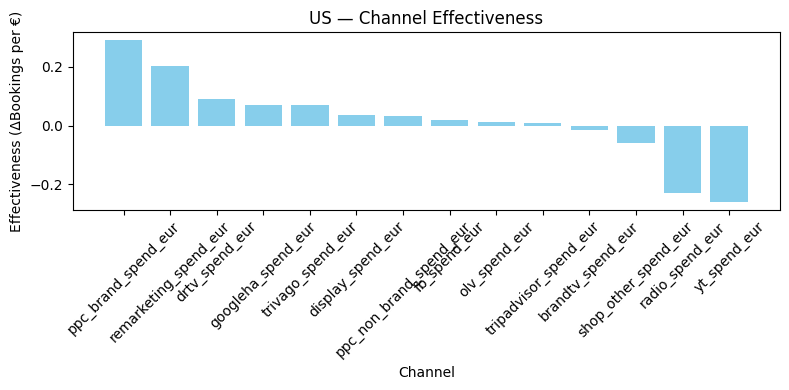

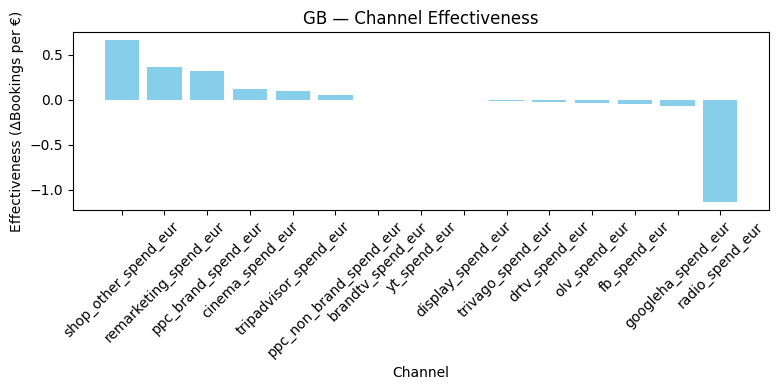

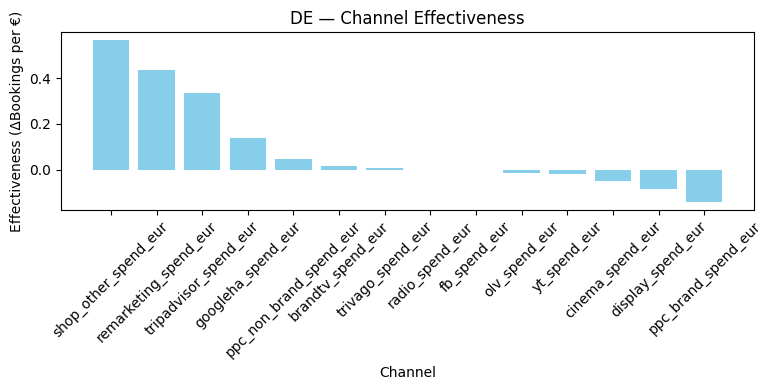

In [14]:
effectiveness_rows = []

# Channel Effectiveness calculation
for ctry in ['us','gb','de']:
    bundle = country_models.get(ctry)
    if not bundle:
        continue
    kind = bundle['kind']
    model = bundle['model']
    d_full = bundle['df_full'].copy()
    trans_meta = bundle['trans_meta'].copy()
    spend_cols_all = channel_feats.copy()
    base_spends_s = d_full[spend_cols_all].mean()
    nonzero_cols = [c for c in spend_cols_all if base_spends_s[c] > 0]
    if len(nonzero_cols) == 0:
        continue
    spend_cols = nonzero_cols
    base_spends = base_spends_s[spend_cols].values
    total_budget = float(base_spends.sum())

    # Prediction function
    def predict_from_spends(sp_vector):
        d2 = d_full.copy()
        for i, c in enumerate(spend_cols):
            d2[c] = sp_vector[i]
        for c in [c for c in spend_cols_all if c not in spend_cols]:
            d2[c] = 0.0

        if kind == 'adhill':
            for c in spend_cols + [c for c in spend_cols_all if c not in spend_cols]:
                d2[f'adhill_{c}'] = apply_channel_transform(d2[c].fillna(0.0).values, trans_meta[c])
            preds = model.predict(d2[bundle['X_cols_adhill']].fillna(0.0).values)
        elif kind == 'loglog':
            for c in spend_cols + [c for c in spend_cols_all if c not in spend_cols]:
                d2[f'log1p_{c}'] = np.log1p(d2[c].fillna(0.0))
            ll, smear = model
            preds = np.maximum(np.exp(ll.predict(d2[bundle['X_cols_ll']].fillna(0.0).values))*smear - 1.0, 0.0)
        else:  # 'elasticnet'
            preds = model.predict(d2[bundle['en_features']].fillna(0.0).values)
        return float(np.mean(preds[bundle['test_idx']]))
    base_pred = predict_from_spends(base_spends)

    # Compute effectiveness per channel
    for i, ch in enumerate(spend_cols):
        eps = max(0.01, 0.01 * base_spends[i])
        sp_eps = base_spends.copy()
        sp_eps[i] += eps
        new_pred = predict_from_spends(sp_eps)
        dy = new_pred - base_pred
        effectiv = dy / eps
        effectiveness_rows.append({'country': ctry, 'channel': ch, 'effectiveness': float(effectiv)})
        
effectiveness_df = pd.DataFrame(effectiveness_rows)
effectiveness_df = effectiveness_df[effectiveness_df['channel'].isin(nonzero_channels)].copy()
eff_pivot = effectiveness_df.pivot_table(index='channel', columns='country', values='effectiveness')
print("Channel Effectiveness by channel & country", eff_pivot.round(4).sort_index())

# Channel Effectiveness plots
for ctry in ['us','gb','de']:
    eff_ctry = effectiveness_df[effectiveness_df['country']==ctry].copy()
    eff_ctry = eff_ctry.sort_values('effectiveness', ascending=False)
    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(eff_ctry['channel'], eff_ctry['effectiveness'], color='skyblue')
    ax.set_title(f"{ctry.upper()} — Channel Effectiveness")
    ax.set_xlabel("Channel"); ax.set_ylabel("Effectiveness (ΔBookings per €)")
    ax.tick_params(axis='x', rotation=45)
    fig.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, f"{ctry}_channel_effectiveness.png"), dpi=150)
    plt.show()

 ## 14) Exports (CSV & Excel)

In [15]:
for ctry, adf in attribution_outputs.items():
    save_csv(adf, f"attribution_{ctry}.csv")

# One Excel workbook with the key sheets
excel_sheets = {
    'country_summary': country_summary,
    'channel_rollup': channel_rollup_long,
    'model_results': model_results_df,
    'elasticities': elas_pivot.round(4),
    'marginal_roi': roi_pivot.round(6),
    'simulations': sim_df,
    'optimization_summary': opt_df,
    'channel_effectiveness': eff_pivot.round(4),
}
if not realloc_df.empty:
    excel_sheets['optimal_reallocation'] = realloc_df
save_excel(excel_sheets, "globestay_results.xlsx")

# Final paths
attr_paths = {ctry: os.path.join(OUTPUT_DIR, f"attribution_{ctry}.csv") for ctry in attribution_outputs}
print({
    "excel_results": os.path.join(OUTPUT_DIR, "globestay_results.xlsx"),
    "attribution_csvs": attr_paths,
    "figures_dir": OUTPUT_DIR
})


Saved: ../output/attribution_us.csv
Saved: ../output/attribution_gb.csv
Saved: ../output/attribution_de.csv
Saved: ../output/globestay_results.xlsx
{'excel_results': '../output/globestay_results.xlsx', 'attribution_csvs': {'us': '../output/attribution_us.csv', 'gb': '../output/attribution_gb.csv', 'de': '../output/attribution_de.csv'}, 'figures_dir': '../output/'}
